# NVIDIA Stock Market History

In [17]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

In [6]:
os.getcwd()

'C:\\Users\\Nigel\\Portfolio\\NVIDIA Stock Market History'

In [2]:
df = pd.read_csv("data/Nvidia_stock_data.csv")

In [3]:
df.head()

,Date,Close,High,Low,Open,Volume
0,1999-01-22,0.037612,0.044775,0.035581,0.040119,2714688000
1,1999-01-25,0.041552,0.042029,0.037612,0.040597,510480000
2,1999-01-26,0.038328,0.042865,0.037731,0.042029,343200000
3,1999-01-27,0.038209,0.039403,0.036298,0.038447,244368000
4,1999-01-28,0.038089,0.038447,0.037850,0.038209,227520000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6637 entries, 0 to 6636
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6637 non-null   object 
 1   Close   6637 non-null   float64
 2   High    6637 non-null   float64
 3   Low     6637 non-null   float64
 4   Open    6637 non-null   float64
 5   Volume  6637 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 311.2+ KB


In [20]:
df['Date'] = pd.to_datetime(df['Date'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6637 entries, 0 to 6636
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6637 non-null   datetime64[ns]
 1   Close   6637 non-null   float64       
 2   High    6637 non-null   float64       
 3   Low     6637 non-null   float64       
 4   Open    6637 non-null   float64       
 5   Volume  6637 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 311.2 KB


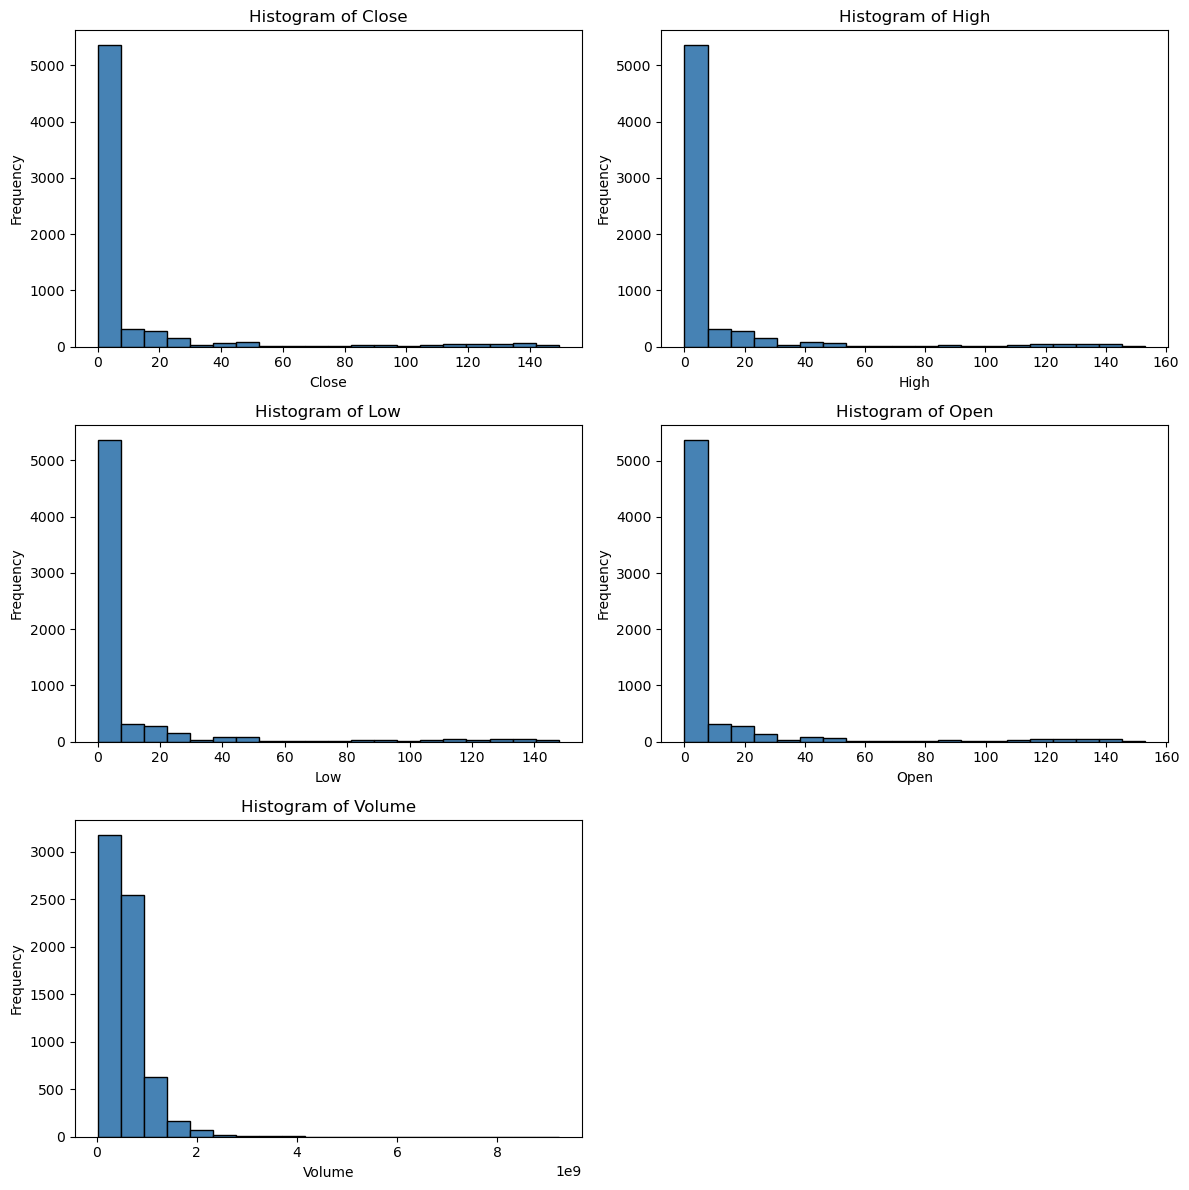

In [18]:
# Drop non-numeric 'Date' column
numeric_df = df.drop(columns=['Date'])

# Determine number of features
features = numeric_df.columns
n_features = len(features)

# Grid layout settings
cols = 2
rows = math.ceil(n_features / cols)

# Create subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()

# Plot each histogram
for i, col in enumerate(features):
    axes[i].hist(numeric_df[col], bins=20, color='steelblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

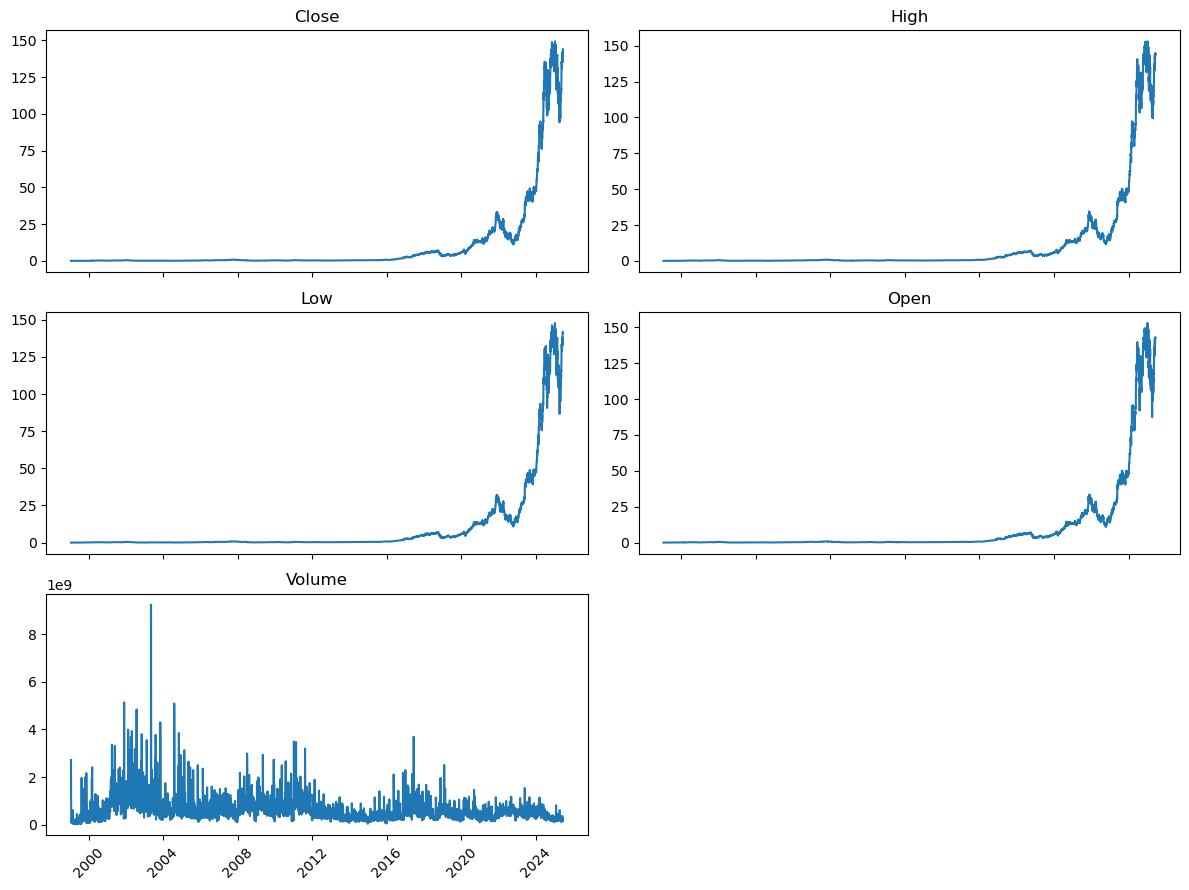

In [22]:
# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3), sharex=True)
axes = axes.flatten()  # Flatten for easy indexing

# Plot each feature as a time series
for i, feature in enumerate(features):
    axes[i].plot(df['Date'], df[feature])
    axes[i].set_title(feature)
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()